## 19. Data analysis

We have seen some elements of data analysis in the previous chapters. For example, we have seen how to extract basic statistics from DataFrames or how to add some regression analysis to plots in seaborn. Here we extend this exploratory analysis and present how true modelling can be performed using SciPy and StatsModels.

## SciPy

Scipy is one of the core packages of the scientific Python ecosystem. It underlies many other domain-specific packages such as as scikit-image (Computer Vision) and implements a large number of complex numerical methods or offers an interface to existing efficient methods (LAPACK, BLAS). Here we only give a few simple examples of the possibilities offered by the package.

### Optimization

Optimization is generally speaking the search for the values of parameters of a function. Typically in data analysis it is used to find the parameters best describing a dataset. Let's say we have measurements $y_i$ at positions $x_i$ and a model $f(x, a)$, our goal is to minimize the distance between the values $y_i$ and the predicted values $y = f(x_i)$, for example by computing $g(a) = \sum{(f(x_i, a) -y_i)^2}$ and then minimizing $\min\limits_{a} g(a)$.

Coming back to our diamonds dataset, we can for example try to create a model for the price vs. carat relation:

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import scipy.optimize

diams = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/Ecdat/Diamond.csv', index_col=0)

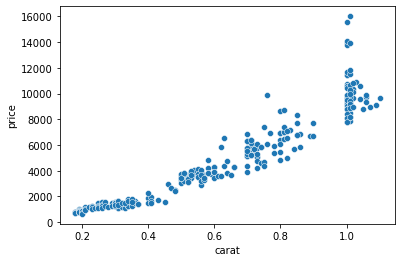

In [2]:
sns.scatterplot(data=diams, x='carat', y='price');

We can define our model as a function. Let's try a simple line:

In [3]:
def fun_line(x, a, b):
    return a * x + b

Now we can directly use the ```curve_fit``` function to fit our data. We only need to specify the function, which should take as first parameter the independent variable ```x``` and then the fitting parameters, and the actual data $x_i$, $y_i$.


In [4]:
fit_params, _ = scipy.optimize.curve_fit(fun_line, diams.carat, diams.price)

In [5]:
fit_params

array([11598.88401383, -2298.35760226])

As output we get the best guess for the fit. The ```curve_fit``` can take **many** additional options for more complex cases. For example you can choose the specific optimization method from an extensive list, specify constraints, initial parameters etc.

Let's check the quality of the fit:

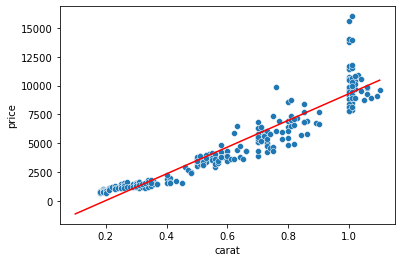

In [6]:
ax = sns.scatterplot(data=diams, x='carat', y='price');
ax.plot(np.arange(0.1, 1.2, 0.1), fun_line(np.arange(0.1, 1.2, 0.1), *fit_params), 'r-');

## Signal processing

SciPy offers an entire module dedicated to signal processing where you can find a large variety of function for filtering, splines, Fourier transforms etc. For example if you have a signal corrupted by additive noise you can use the Wiener filter out of the box. Let's create some artificial noisy data:

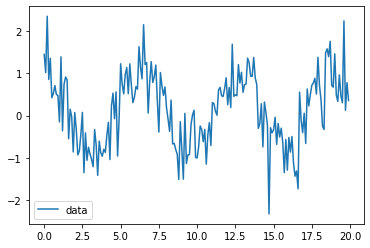

In [7]:
x_vect = np.arange(0,20,0.1)
y_vect = np.cos(x_vect) + 0.5*np.random.randn(len(x_vect))

sns.lineplot(x=x_vect, y=y_vect, label='data');

Now we create a filtered version of the data using the Wiener filter:

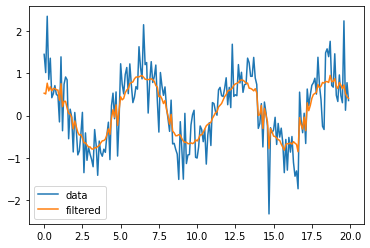

In [8]:
import scipy.signal

filterd_y = scipy.signal.wiener(y_vect, 20)
ax = sns.lineplot(x=x_vect, y=y_vect, label='data')
sns.lineplot(x=x_vect, y=filterd_y, label='filtered');

The package contains also useful analysis functions e.g. to find peaks in a signal. For example, let's try to find peaks in our noisy signal above:

In [9]:
peaks, props = scipy.signal.find_peaks(x=y_vect) 

What is returned here is a list of indices where a local maximum was found. We can use that list to plot them:

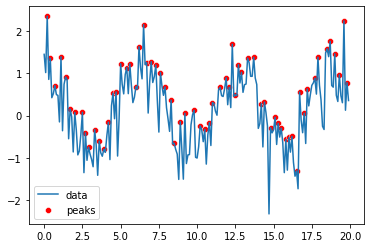

In [10]:
ax = sns.lineplot(x=x_vect, y=y_vect, label='data')
sns.scatterplot(x=x_vect[peaks], y=y_vect[peaks], label='peaks', color='red');

We can then use options proposed in the function to improve the results. For example we can set a window within which to search for local maxima and a minimal height:

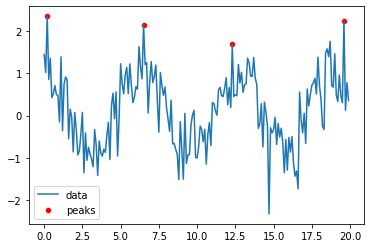

In [11]:
peaks, props = scipy.signal.find_peaks(x=y_vect, distance=30, height=0)
ax = sns.lineplot(x=x_vect, y=y_vect, label='data')
sns.scatterplot(x=x_vect[peaks], y=y_vect[peaks], label='peaks', color='red');

## statsmodels

The statsmodels package is entirely dedicated to regression, statistical analysis and test. Of course it partially overlaps with other packages (for example curve fitting in SciPy), but it provides in a simple way standard statistical information not readily available otherwise.

### Ordinary Least Squares

OLS allow one to fit linear models (liner in the coefficients) to datasets and estimate the quality of the fit. For example we can perform the same fit as we did above for the price vs. carat data. First we load the main module:

In [12]:
import statsmodels.api as sm

For our fit, we need now to provide a dependent (price) and an independent variable (carat). Our model does not necessarily reduce to a *simple linear model* but could have dependencies on multiple variables. All variables can be passed to the fitting model as Pandas DataFrames or Series. For the start let's just use price and carat in our OLS model:

In [13]:
model = sm.OLS(diams.price, diams.carat)

This returns a ```model``` object (similarly to scikit-learn), and now we have to *execute* the fit:

In [14]:
res = model.fit()

The ```res``` object contains all the information about our fit. In particular we can have a look at a summary:

In [15]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              5081.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):                   4.65e-193
Time:                        16:22:29   Log-Likelihood:                         -2678.4
No. Observations:                 308   AIC:                                      5359.
Df Residuals:                     307   BIC:                                      5362.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
carat       8543.7399    119.855     71.284      0.000    8307.899    8779.581
==============================================================================
Omnibus:                      173.273   Durbin-Watson:                   0.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1029.681
Skew:                           2.348   Prob(JB):                    2.56e-224
Kurtosis:                      10.627   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can alos use the fitting information to generate a plot e.g. by using the ```predict``` method: 

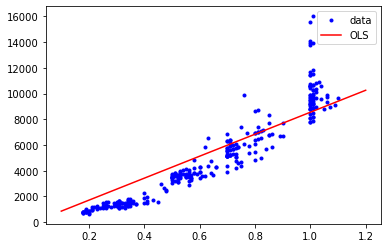

In [16]:
import matplotlib.pyplot as plt

plt.plot(diams.carat, diams.price, "b.", label="data")
plt.plot(np.arange(0.1,1.25,0.1), res.predict(np.arange(0.1,1.25,0.1)), "r-", label="OLS")
plt.legend()

We see that our model is too high. The reason for this is that at the moment, our model is simply $y=a*x$ and thus the intercept is at 0. We can add an intercept to the model by adding a constant column to our independent variables:

In [17]:
indep_var = sm.add_constant(diams.carat, prepend=False)
indep_var.head(5)

,carat,const
1,0.30,1.0
2,0.30,1.0
3,0.30,1.0
4,0.30,1.0
5,0.31,1.0


Now we can fit again. Note that for the prediction, we need to create an array (or dataframe) with the correct dimensions, here two columns, one for the carat, the other for the constant.

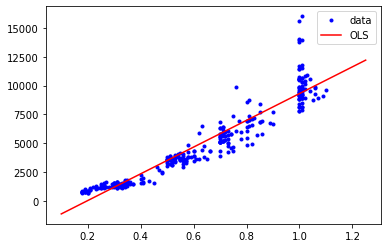

In [18]:
model = sm.OLS(diams.price, indep_var)
res = model.fit()
plt.plot(diams.carat, diams.price, "b.", label="data")
plt.plot(np.linspace(0.1,1.25,10), res.predict(np.column_stack((np.linspace(0.1,1.25,10), np.ones(10)))), "r-", label="OLS");
plt.legend();


Finally, we can try to use a more complex model. Remember that we have a linear model in the *coefficients* but we can use a more complex model like $y = a * x + b * x^2 + c$. For this we add ourselves a quadratic variable in the table:

In [19]:
indep_var['sq'] = diams.carat**2
indep_var.head(5)

,carat,const,sq
1,0.30,1.0,0.0900
2,0.30,1.0,0.0900
3,0.30,1.0,0.0900
4,0.30,1.0,0.0900
5,0.31,1.0,0.0961


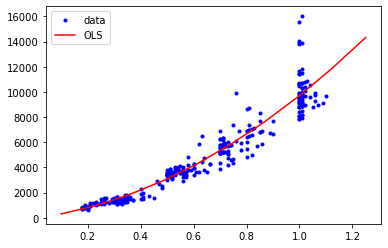

In [26]:
model = sm.OLS(diams.price, indep_var)
res = model.fit()
plt.plot(diams.carat, diams.price, "b.", label="data")
plt.plot(np.linspace(0.1,1.25,10), res.predict(np.column_stack((np.linspace(0.1,1.25,10), np.ones(10), np.linspace(0.1,1.25,10)**2))), "r-", label="OLS")
plt.legend();


In [29]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1565.
Date:                Wed, 02 Mar 2022   Prob (F-statistic):          4.29e-161
Time:                        16:24:45   Log-Likelihood:                -2568.4
No. Observations:                 308   AIC:                             5143.
Df Residuals:                     305   BIC:                             5154.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
carat       2786.0994   1119.615      2.488      0.013     582.953    4989.246
const        -42.5072    316.369     -0.134      0.893    -665.050     580.036
sq          6961.7059    868.825      8.013      0.000    5252.055    8671.357
==============================================================================
Omnibus:                      178.954   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1680.735
Skew:                           2.232   Prob(JB):                         0.00
Kurtosis:                      13.538   Cond. No.                         32.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### With functions

We can achieve the same results as above by explicitly defining a function using the ols submodule similarly to what you can do in the R world:

In [37]:
from statsmodels.formula.api import ols

res = ols("price ~  carat + I(carat**2)", data=diams).fit()

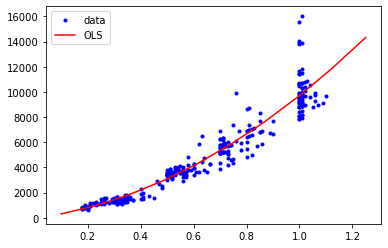

In [38]:
plt.plot(diams.carat, diams.price, "b.", label="data")
plt.plot(np.linspace(0.1,1.25,10), res.predict(np.column_stack((np.ones(10), np.linspace(0.1,1.25,10), np.linspace(0.1,1.25,10)**2)), transform=False), "r-", label="OLS")
plt.legend();


Now that we have a fit, we can check for its quality. For example, we can have a look at the residuals:

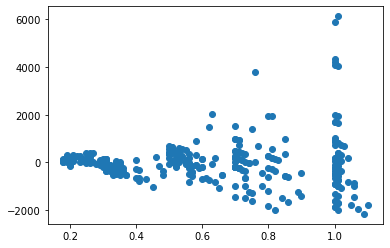

In [43]:
plt.plot(diams.carat, res.resid,'o');

The package also offers a stats module that contains a large collection of statistical test. For example we can check whether our residuals are distributed following a normal distribution using the Jarque-Bera test:

In [48]:
import statsmodels.stats.api as sms

In [49]:
test = sms.jarque_bera(res.resid)

In [50]:
test

(1680.7354277013312, 0.0, 2.231566811291951, 13.537876220126197)

This is just a very short introduction to statstmodels which contains many more models, tools for times series analysis, advanced statistics, tools for plots etc.

## Exercise

1. Use ```scipy.optimize.curve_fit``` to fit now a parabola (with a $x^2$ term) to the price vs. carat data. Import the data with:

In [56]:
import pandas as pd
diams = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/Ecdat/Diamond.csv', index_col=0)

2. You are given the noise data below. Try to find the local *minima* by first without then with filtering the data with a Wiener filter.

In [144]:
x_vect = np.arange(0,20,0.1)
y_vect = 2*x_vect + 3*np.cos(x_vect) + 1*np.random.randn(len(x_vect))

3. Try to do an ordinary least square fit of the signal knowing there's a ```cos``` component: